## FPA

This class represents standard Cuckoo Search based on the explanation in the [\[book\]](https://doi.org/10.1016/B978-0-12-416743-8.00009-9) Nature-Inspired Optimization Algorithms by Xin-She Yang and his implementation of standard Cuckoo Search in Matlab on [\[mathworks\]](https://www.mathworks.com/matlabcentral/fileexchange/29809-cuckoo-search-cs-algorithm). The implementation is slightly different to the flow of the algorithm described in the book. The figures below describe the pseudocode of the algorithm from the book, and the flow of the implementation. The GRW stands for Global Random Walk by Levy Flight, and the LRW stands for Local Random Walk.

1) **Initial Population:**: A starting population is sampled in the beginning. In this framework, this can be either a [Sampling](../operators/sampling.ipynb) object, which defines different initial sampling strategies, or `Population` where the `X` and `F` values are set, or a simple NumPy array (pop_size x n_var).

2) **Evaluation:** It is executed using the problem defined to be solved.

3) **Survival:** The survival mechanism used is by default the survival of the fittest for the Elitism.

4) **Global Random Walk:** The global random walks use a step size that is generated based on Levy Flight Distribution. Every dimension will have its own randomly generated step size on every operation. The Global Random Walk can be done following the book which to randomly choose solution $x_{i}$ which will be modified by Global Random Walk resulting in $x'_i$ and replace a randomly chosen solution $x_{j}$, if $x'_{i}$ is better than $x_{j}$. However for simplicity sake, as also been done in the matlab implementation, $x'_{i}$ will be compared to $x_{i}, \forall i$ in every iteration. 

5) **Local Random Walk:** After the Global Random Walk has been done, including the replacement after improvement, every nest $x_i$ has a $p_a$ probability to create new solution via Local Ranom Walk $x'_i = x_i + \alpha_0*(x_j-x_k)$ with $x_j$ and $x_k$ are two different randomly selected nest. Afterwards, combine the old nests with the new generated nests via Local Random Walks. The size of the combined nests will be pop_size $\leq$ combined_pop_size $\leq 2$pop_size. Survival mechanism thus will be used to select a number of pop_size best nests.



<div style="display: block;margin-left: auto;margin-right: auto;width: 60%;">
![cs_pseudocode](../resources/images/cuckoo_search_pseudocode.png)
</div>

<div style="display: block;margin-left: auto;margin-right: auto;width: 60%;">
![cs_flow](../resources/images/cuckoo_search_flow.png)
</div>

### Example

In [301]:
import numpy as np

from pymoo.algorithms.so_cuckoo_search import MantegnasAlgorithm
from pymoo.algorithms.nsga2 import RankAndCrowdingSurvival
from pymoo.algorithms.so_fpa import FlowerPollinationAlgorithm
from pymoo.decomposition.weighted_sum import WeightedSum
from pymoo.docs import parse_doc_string
from pymoo.model.infill import InfillCriterion
from pymoo.model.population import Population
from pymoo.model.replacement import ImprovementReplacement
from pymoo.operators.repair.to_bound import set_to_bounds_if_outside
from pymoo.operators.sampling.latin_hypercube_sampling import LHS
from pymoo.util.reference_direction import sample_on_unit_simplex
from pymoo.util.display import MultiObjectiveDisplay
from pymoo.util.termination.default import MultiObjectiveDefaultTermination

# =========================================================================================================
# Implementation
# =========================================================================================================
class AdaptiveLevyFlight:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        #beta must be in range of [1..2]
        beta = min(beta, 2)
        beta = max(beta, 1)
        self.beta = beta            
        self.cauchy = np.random.default_rng().standard_cauchy
        self.gaussian = np.random.default_rng().standard_normal        
        self.levy = MantegnasAlgorithm(beta)        
    
    def _do(self, xr, xi, xl, xu):
        # get random levy/cauchy/gaussian values to be used for the step size
        if self.beta == 1:
            levy = self.cauchy(len(xi))
        elif self.beta == 2:
            levy = self.gaussian(len(xi))
        else:
            levy = self.levy.do(len(xi))
        direction = (xr-xi)
        _x = xi + (xu - xl)*self.alpha * levy * direction        
        return _x

class LocalPollination:    
    def _do(self, X, xi, xl, xu, n_offsprings):
        #find n_offsprings*2 different solutions (n_offsprings pair) 
        Pair = np.random.permutation(X)[:2*n_offsprings]
        R1, R2 = Pair[:n_offsprings], Pair[n_offsprings:2*n_offsprings]
        r = np.random.rand()
        _X = xi + r*(R1-R2)        
        return _X
    
class MO_ALFPA(FlowerPollinationAlgorithm):

    def __init__(self,
                 pop_size=100,
                 alpha=0.1,
                 mating=None,
                 p=0.8,
                 e=0.05,
                 sampling=LHS(),
                 termination=None,
                 display=MultiObjectiveDisplay(),
                 survival=RankAndCrowdingSurvival(),
                 **kwargs):
        """

        Parameters
        ----------

        sampling : {sampling}

        termination : {termination}

        pop_size : int
         The number of solutions

        beta : float
            The input parameter of the Mantegna's Algorithm to simulate
            sampling on Levy Distribution

        alpha : float
            The step size scaling factor and is usually 0.1.

        pa : float
            The switch probability, pa fraction of the nests will be abandoned on every iteration
        """
        
        super().__init__(pop_size=pop_size,
                         sampling=sampling,
                         termination=termination,
                         display=display,
                         mating=mating,
                         survival=survival,
                         **kwargs)
        
        cauchy = AdaptiveLevyFlight(alpha, 1)
        gaussian = AdaptiveLevyFlight(alpha, 2)
        levy1 =  AdaptiveLevyFlight(alpha, 1.3)
        levy2 = AdaptiveLevyFlight(alpha, 1.7)
        lrw = LocalPollination()
        self.mating = [cauchy, gaussian, levy1, levy2, lrw]
        self.index = np.arange(self.pop_size)
        self.e = e
        
        #estimate max_gen from max_eval
        self.max_gen = 25000/(self.pop_size)
        self.p0 = p
        self.p = p
    
    def _initialize(self):
        super()._initialize()
        self.ideal_point = np.min(self.pop.get("F"), axis=0)
        self.opt = self.survival._do(self.problem, self.pop, self.pop_size)
        self.opt = self.opt[self.opt.get("rank")==0]
        
    def _set_optimum(self):
        return
    
    def _is_e_dominate(self, fa, Fb):
        #get box
        ba = self.e*np.floor((fa-self.ideal_point)/ self.e) 
        Bb = self.e*np.floor((Fb-self.ideal_point)/ self.e)
        #check if exist a box of Bb dominates box ba
        #if exist then not inserting
        #b_not_worse = np.all(Bb <= ba, axis=1)
        #b_better = np.any(Bb < ba, axis=1)
        #b_dominate = np.logical_and(b_not_worse, b_better)
        exist_b_dominate = np.any(np.logical_and(np.all(Bb<=ba, axis=1), np.any(Bb < ba, axis=1)))
        if exist_b_dominate:
            return

        #check all boxes Bb dominated by ba
        ba_dominate = np.logical_and(np.all(ba <= Bb, axis=1), np.any(ba < Bb, axis=1))
        #check all boxes Bb same as ba
        same_box = np.all(ba == Bb, axis=1)

        #if ba doesn't dominate any box and there isn't the same box then just insert and return
        if not np.any(ba_dominate) and not np.any(same_box):        
            return None

        #then handle all other cases
        #if same box check if fa dominates Fb
        fa_dominate = np.logical_and(np.all(fa <= Fb, axis=1), np.any(fa < Fb, axis=1))
        #if same box check if fa is dominated by Fb
        Fb_dominate = np.logical_and(np.all(Fb <= fa, axis=1), np.any(Fb < fa, axis=1))
        #calculate distance to own boxes
        distA = np.linalg.norm(fa-ba)
        distB = np.linalg.norm(Fb-Bb)
        #check distance to boxes is closer
        closer_to_box = distA < distB

        dominate_or_closer = np.logical_or(fa_dominate, closer_to_box)
        same_box_and_dominate_or_closer = np.logical_and(same_box, dominate_or_closer)
        fa_e_dominate = np.logical_or(ba_dominate, same_box_and_dominate_or_closer)
        return fa_e_dominate
    
    def _insert_to_opt(self, offs):        
        _F = offs.get("F")
        F = self.opt.get("F")
        
        for idx in range(len(_F)):
            _f = _F[idx]
            I = self._is_e_dominate(_f, F)
            if I is None: #_f is box-dominated
                continue
            #else, no solution in F e-dominated _f 
            #delete e-dominated solutions
            F = np.vstack((F[~I], _f))
            self.opt = Population.merge(self.opt[~I], offs[idx])
           
    def _next(self):
        X = self.pop.get("X")
        F = self.pop.get("F")
        rank = self.pop.get("rank")
        xl, xu = self.problem.bounds()
        offs = Population()
        index_permute = np.random.permutation(self.index)[:int(self.pop_size/4)]
        
        for i in index_permute:
            xi = X[i]
            #pick operator GRW or LRW
            #GRW = operators 1-4
            #LRW = operator 5 with n_offsprings=4
            _X = []
            if np.random.rand() <= self.p:                
                r = np.random.randint(self.pop_size)
                xr = np.random.permutation(X[rank==0])[0]
                for op in range(4):
                    _x = self.mating[op]._do(xr, xi, xl, xu)
                    _X = _X + [_x]                
            else:
                _X = self.mating[4]._do(X, xi, xl, xu, 4)
            _X = set_to_bounds_if_outside(np.array(_X), xl, xu)
            off = Population.new(X=_X)
            offs = Population.merge(offs, off)        
                
        # replace the individuals in the population
        self.evaluator.eval(self.problem, offs, algorithm=self)
        self._insert_to_opt(offs)
        self.pop = Population.merge(self.pop, offs)
        self.pop = self.survival._do(self.problem, self.pop, self.pop_size)
        self.ideal_point = np.min(self.pop.get("F"), axis=0)
        #updating p
        self.p = self.p0 - 0.3*(self.n_gen/self.max_gen)

parse_doc_string(MO_ALFPA.__init__)


2.6513772010803223


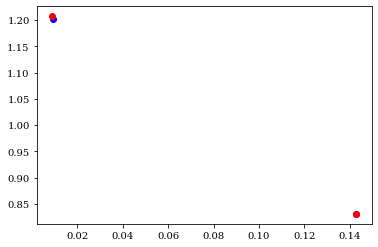

In [314]:
# from pymoo.algorithms.mofpa import MOFPA
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")
n_obj=2
algorithm = MO_ALFPA(e=0.01)

res = minimize(problem, algorithm, ('n_gen', 100), seed=1, verbose=False, save_history=True)

print(res.exec_time)
# if n_obj == 2:
#     plot = Scatter()
#     plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
#     plot.add(res.opt.get("F"), color="red")
#     plot.show()
# else:
#     plot = Scatter().add(res.F)
#     plot.show()


import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig2 = plt.figure()
def animate(i):
    if (i>0):
        _F = res.history[i-1].opt.get("F")
    else:
        _F = None
    F = res.history[i].opt.get("F")
    plt.clf()
    
    if _F is not None:
        return plt.scatter(_F[:,0], _F[:,1], color="blue"), plt.scatter(F[:,0], F[:,1], color="red"), 
    else:
        return plt.scatter(F[:,0], F[:,1], color="red"),
im_ani = animation.FuncAnimation(fig2, animate, interval=5000, blit=True)
im_ani.save('test.gif')
plt.show()


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
A = np.array([1,2])
B = np.array([3,4])
print(np.linalg.norm(A-B))
print(np.sqrt(8))

In [298]:
A = np.array([[x*0.05, 1-x*0.05] for x in range(100)])

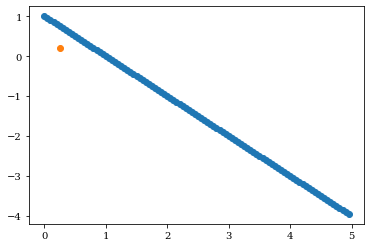

[False False False False False  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


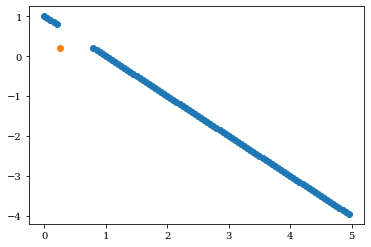

In [300]:
B = np.array([0.25, 0.2])
ideal_point = np.array([0, 0])
e = 0.05
def is_e_dominate(fa, Fb):
    #get box
    ba = e*np.floor((fa-ideal_point)/ e) 
    Bb = e*np.floor((Fb-ideal_point)/ e)
    #check if exist a box of Bb dominates box ba
    #if exist then not inserting
    #b_not_worse = np.all(Bb <= ba, axis=1)
    #b_better = np.any(Bb < ba, axis=1)
    #b_dominate = np.logical_and(b_not_worse, b_better)
    exist_b_dominate = np.any(np.logical_and(np.all(Bb<=ba, axis=1), np.any(Bb < ba, axis=1)))
    if exist_b_dominate:
        return
    
    #check all boxes Bb dominated by ba
    ba_dominate = np.logical_and(np.all(ba <= Bb, axis=1), np.any(ba < Bb, axis=1))
    #check all boxes Bb same as ba
    same_box = np.all(ba == Bb, axis=1)
    
    #if ba doesn't dominate any box and there isn't the same box then just insert and return
    if not np.any(ba_dominate) and not np.any(same_box):
        #insert
        return 
    
    #then handle all other cases
    #if same box check if fa dominates Fb
    fa_dominate = np.logical_and(np.all(fa <= Fb, axis=1), np.any(fa < Fb, axis=1))
    #if same box check if fa is dominated by Fb
    Fb_dominate = np.logical_and(np.all(Fb <= fa, axis=1), np.any(Fb < fa, axis=1))
    #calculate distance to own boxes
    distA = np.linalg.norm(fa-ba)
    distB = np.linalg.norm(Fb-Bb)
    #check distance to boxes is closer
    closer_to_box = distA < distB
    
    dominate_or_closer = np.logical_or(fa_dominate, closer_to_box)
    same_box_and_dominate_or_closer = np.logical_and(same_box, dominate_or_closer)
    fa_e_dominate = np.logical_or(ba_dominate, same_box_and_dominate_or_closer)
    return fa_e_dominate
    #mask the opt and then insert

import matplotlib.pyplot as plt
plt.scatter(A[:,0], A[:, 1])
plt.scatter(B[0],B[1])
plt.show()

I = is_e_dominate(B,A)
print(I)
if I is not None:
    C = A[~is_e_dominate(B,A)]
    plt.scatter(C[:,0],C[:,1])
    plt.scatter(B[0],B[1])
    plt.show()

In [167]:
C = np.array([[1,2,3],[1,3,3]])
C = np.vstack((C, np.array([1,2,2])))
print(C)
D = np.array([1,2,3])
print(np.all(C==D, axis=1))
print(np.divide(0.25,0.05))
F = np.array([0.25])
N = np.array([0.])
print(np.floor((F-N)/0.05))

[[1 2 3]
 [1 3 3]
 [1 2 2]]
[ True False False]
5.0
[5.]


### API